In [ ]:
#@title Copyright 2023 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Species Distribution Modeling
Author: osgeokr
Adapted: Rui Figueira

In this tutorial, the methodology of Species Distribution Modeling was adapted from a Google Earth Engine workflow (https://developers.google.com/earth-engine/tutorials/community/species-distribution-modeling) to a local run using local python libraries. A brief overview of Species Distribution Modeling  will be provided, followed by the process of predicting and analyzing the habitat of species of interest.

## A brief overview of Species Distribution Modeling

Let's explore what species distribution models are, the required data for the models, and how the workflow is structured.

### What is Species Distribution Modeling?

Species Distribution Modeling (SDM below) is the most common methodology used to estimate the actual or potential geographic distribution of a species. It involves characterizing the environmental conditions suitable for a particular species and then identifying where these suitable conditions are distributed geographically.

SDM has emerged as a crucial component of conservation planning in recent years, and various modeling techniques have been developed for this purpose. While there isa wealth of implementations in R, the same cannot be said for python. Nevetherless, all the necessary libraries and experience exist from the data science applications, with powerful computing capabilities and support for machine learning algorithms, allowing for rapid modeling.

  > Note: Conservation biologist Dr. Ramiro D. Crego implemented SDM using the GEE JavaScript Code Editor and published his research findings [(Crego et al, 2022)](https://onlinelibrary.wiley.com/doi/10.1111/ddi.13491). The methodology of SDM introduced here has been translated and modified from the [JavaScript source code](https://smithsonian.github.io/SDMinGEE/) he shared into the Python language.

### Data Required for SDM

SDM typically utilizes the relationship between known species occurrence records and environmental variables to identify the conditions under which a population can sustain. In other words, two types of model input data are required:

1. Occurrence records of known species
1. Various environmental variables

These data are input into algorithms to identify environmental conditions associated with the presence of species.

### Workflow of SDM

The workflow for SDM is as follows:

1. Collection and preprocessing of species occurrence data
1. Definition of the Area of Interest
1. Addition of environmental variables
1. Generation of pseudo-absence data
1. Model fitting and prediction
1. Variable importance and accuracy assessment

## Habitat Prediction and Analysis Using GEE

The [Fairy pitta (*Pitta nympha*)](https://datazone.birdlife.org/species/factsheet/22698684) will be used as a case study to demonstrate the application of GEE-based SDM. While this specific species has been selected for one example, researchers can apply the methodology to any target species of interest with slight modifications to the provided source code.

The Fairy pitta is a rare summer migrant and passage migrant in South Korea, whose distribution area is expanding due to recent climate warming on the Korean Peninsula. It is classified as a rare species, endangered wildlife of class II, Natural Monument No. 204, evaluated as Regionally Extinct (RE) in the National Red List, and Vulnerable (VU) according to the IUCN categories.

Conducting SDM for the conservation planning of the Fairy pitta appears to be quite valuable. Now, let's proceed with habitat prediction and analysis through GEE.

First, the Python libraries are imported.The `import` statement brings in the entire contents of a module, while the `from import` statement allows for the importation of specific objects from a module.

In [1]:
# Import libraries
import pandas as pd, geopandas as gpd
import numpy as np, matplotlib.pyplot as plt
import os, requests, math, random

from ipyleaflet import TileLayer
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Collection and Preprocessing of Species Occurrence Data

You need to provide occurrence data for your species of interest. The following implements a way of getting observational data about specific species through the GBIF API. The [GBIF API](https://techdocs.gbif.org/en/openapi/) is an interface that allows access to the species distribution data provided by GBIF, enabling users to search, filter, and download data, as well as acquire various information related to species.

In the code below, the `species_name` variable is assigned the scientific name of the species (e.g., *Pitta nympha* for Fairy pitta), and the `country_code` variable is assigned the country code (e.g., KR for South Korea). The `base_url` variable stores the address of the GBIF API. `params` is a dictionary containing parameters to be used in the API request:

* `scientificName`: Sets the scientific name of the species to be searched.
* `country`: Limits the search to a specific country.
* `hasCoordinate`: Ensures only data with coordinates (true) are searched.
* `basisOfRecord`: Chooses only records of human observation (`HUMAN_OBSERVATION`).
* `limit`: Sets the maximum number of results returned to 10000.

**Skip if you have already your occurrence data in a csv file!**

In [ ]:
def get_gbif_species_data(species_name, country_code):
    """
    Retrieves observational data for a specific species using the GBIF API and returns it as a pandas DataFrame.

    Parameters:
    species_name (str): The scientific name of the species to query.
    country_code (str): The country code of the where the observation data will be queried.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the observational data.
    """
    base_url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,
        "country": country_code,
        "hasCoordinate": "true",
        "basisOfRecord": "HUMAN_OBSERVATION",
        "limit": 10000,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raises an exception for a response error.
        data = response.json()
        occurrences = data.get("results", [])

        if occurrences:  # If data is present
            df = pd.json_normalize(occurrences)
            return df
        else:
            print("No data found for the given species and country code.")
            return pd.DataFrame()  # Returns an empty DataFrame
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return pd.DataFrame()  # Returns an empty DataFrame in case of an exception

Using the parameters set previously, we query the GBIF API for observational records of the Fairy pitta (*Pitta nympha*), and load the results into a DataFrame to check the first row. A DataFrame is a data structure for handling table-formatted data, consisting of rows and columns. If necessary, the DataFrame can be saved as a CSV file and read back in.

In [2]:
# Retrieve Fairy Pitta data
# df = get_gbif_species_data("Pitta nympha", "KR")
df = pd.read_csv("../dados_sps/dados_sps.csv")
"""
# Save DataFrame to CSV and read back in.
df.to_csv("pitta_nympha_data.csv", index=False)
df = pd.read_csv("pitta_nympha_data.csv")
"""
df.head(1)  # Display the first row of the DataFrame

,ID,species,Longitude,Latitude,year,month
0,1,TriticumAestivum,13.005361,54.141279,1991,11


Next, we convert the DataFrame into a GeoDataFrame that includes a column for geographic information (`geometry`) and check the first row. A GeoDataFrame can be saved as a GeoPackage file (*.gpkg) and read back in.

In [3]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude,
                                df.Latitude),
    crs="EPSG:4326"
)[["species", "year", "month", "geometry"]]
"""
# Convert GeoDataFrame to GeoPackage (requires pycrs module)
%pip install -U -q pycrs
gdf.to_file("pitta_nympha_data.gpkg", driver="GPKG")
gdf = gpd.read_file("pitta_nympha_data.gpkg")
"""
gdf.head(1)  # Display the first row of the GeoDataFrame

,species,year,month,geometry
0,TriticumAestivum,1991,11,POINT (13.00536 54.14128)


Check if there are missing of NA values in your file.

In [4]:
# chedk for missing values
gdf.isnull().any()

species     False
year        False
month       False
geometry    False
dtype: bool

In [5]:
# chedk for NA values
gdf.isna().any()

species     False
year        False
month       False
geometry    False
dtype: bool

Remove empty or invalid geometries

In [6]:
# Remove empty or invalid geometries
filtered_gdf = gdf[gdf.geometry.notnull()].copy()
filtered_gdf = gdf[gdf.is_valid].copy()

Next, we will define the raster pixel size of the SDM results as 1km resolution.

In [7]:
# Spatial resolution setting (meters)
grain_size = 1000

When multiple occurrence points are present within the same 1km resolution raster pixel, there is a high likelihood that they share the same environmental conditions at the same geographic location. Using such data directly in the analysis can introduce bias into the results.

In other words, we need to limit the potential impact of geographic sampling bias. To achieve this, we will retain only one location within each 1km pixel and remove all others, allowing the model to more objectively reflect the environmental conditions.

In [8]:
# good code
# Remove duplicates within the specified grain size

import geopandas as gpd
import numpy as np

def remove_duplicates_local(gdf, grain_size):
    """
    Keep only one random occurrence per grid cell of given grain_size.
    """

    # Drop invalid/null/empty geometries
    gdf = gdf[gdf.geometry.notnull()].copy()
    gdf = gdf[gdf.is_valid].copy()
    gdf = gdf[~gdf.geometry.is_empty].copy()

    # Ensure data is in WGS84 before filtering coordinates
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=4326)
    else:
        gdf = gdf.to_crs(epsg=4326)

    # Filter out invalid lat/lon values
    gdf = gdf[
        (gdf.geometry.x >= -180) & (gdf.geometry.x <= 180) &
        (gdf.geometry.y >= -90) & (gdf.geometry.y <= 90)
    ].copy()

    # Now project to meters
    gdf = gdf.to_crs(epsg=3857)

    # Extract coordinates
    x = gdf.geometry.x
    y = gdf.geometry.y

    # Compute grid indices
    gdf["col"] = np.floor(x / grain_size).astype("Int64")
    gdf["row"] = np.floor(y / grain_size).astype("Int64")

    # Assign random values and keep one per cell
    gdf["rand"] = np.random.rand(len(gdf))
    gdf = gdf.sort_values("rand").drop_duplicates(subset=["row", "col"])

    # Drop helper cols
    gdf = gdf.drop(columns=["col", "row", "rand"])

    return gdf


In [9]:
# Make sure data is in WGS84 for coordinate checks
gdf = filtered_gdf.to_crs(epsg=4326)

# Find invalid lat/lon values
bad_coords = gdf[
    (gdf.geometry.x < -180) | (gdf.geometry.x > 180) |
    (gdf.geometry.y < -90)  | (gdf.geometry.y > 90)
]

print("Number of bad records:", len(bad_coords))
print(bad_coords.head())


Number of bad records: 80
              species  year  month                geometry
163  TriticumAestivum  1987      2  POINT (10945 51.01028)
216  TriticumAestivum  1992      4   POINT (11.1812 52066)
227  TriticumAestivum  1996     10  POINT (11.58828 52099)
514  TriticumAestivum  2005      4   POINT (7445 48.66806)
552  TriticumAestivum  1980     10   POINT (4925 50.74861)


In [10]:
# Keep only valid lat/lon records
gdf_clean = gdf[
    (gdf.geometry.x >= -180) & (gdf.geometry.x <= 180) &
    (gdf.geometry.y >= -90)  & (gdf.geometry.y <= 90)
].copy()


In [11]:
# Identify points with invalid coordinates

bad_coords = filtered_gdf[
    (filtered_gdf.geometry.x < -180) | (filtered_gdf.geometry.x > 180) |
    (filtered_gdf.geometry.y < -90) | (filtered_gdf.geometry.y > 90)
]
print(bad_coords)

               species  year  month                geometry
163   TriticumAestivum  1987      2  POINT (10945 51.01028)
216   TriticumAestivum  1992      4   POINT (11.1812 52066)
227   TriticumAestivum  1996     10  POINT (11.58828 52099)
514   TriticumAestivum  2005      4   POINT (7445 48.66806)
552   TriticumAestivum  1980     10   POINT (4925 50.74861)
...                ...   ...    ...                     ...
9387  TriticumAestivum  2014      6    POINT (4387 48.4413)
9404  TriticumAestivum  2011      4      POINT (8485 47.49)
9738  TriticumAestivum  1987      5   POINT (8.87536 49783)
9851  TriticumAestivum  1985      4      POINT (4301 48004)
9971  TriticumAestivum  2015      1   POINT (9.53316 47353)

[80 rows x 4 columns]


In [12]:
coords = filtered_gdf.to_crs(epsg=3857).geometry
print("Has NaN:", coords.isna().sum())
print("Has Inf:", np.isinf(coords.x).sum() + np.isinf(coords.y).sum())


Has NaN: 0
Has Inf: 156


In [13]:
# good code
# Remove points with invalid coordinates

# filtered_gdf = gpd.read_file("occurrences.shp")
grain_size = 1000  # 1 km
data_thinned = remove_duplicates_local(gdf_clean, grain_size)

print("Original data size:", len(filtered_gdf))
print("Final data size:", len(data_thinned))


Original data size: 10000
Final data size: 9579


In [14]:
data_thinned

,species,year,month,geometry
847,TriticumAestivum,2006,9,POINT (650114.509 6584064.126)
7291,TriticumAestivum,2001,1,POINT (-239996.251 5250713.883)
1082,TriticumAestivum,1991,8,POINT (1360860.96 6525856.25)
6469,TriticumAestivum,2005,12,POINT (154313.305 6406083.746)
3943,TriticumAestivum,2005,9,POINT (817229.666 5955270.878)
...,...,...,...,...
420,TriticumAestivum,2004,3,POINT (-177050.644 6131519.015)
4319,TriticumAestivum,1996,6,POINT (1662252.359 7370787.434)
3335,TriticumAestivum,2013,2,POINT (639737.084 6579415.28)
281,TriticumAestivum,1984,8,POINT (591428.209 5716190.086)


The visualization comparing geographic sampling bias before preprocessing (in blue) and after preprocessing (in red) is shown below. To facilitate comparison, the map has been centered on the area with a high concentration of Fairy pitta occurrence coordinates in Hallasan National Park.

### Definition of the Area of Interest

Defining the Area of Interest (AOI below) refers to the term used by researchers to denote the geographical area they want to analyze. It has a similar meaning to the term Study Area.

In this context, we obtained the bounding box of the occurrence point layer geometry and created a 50-kilometer buffer around it (with a maximum tolerance of 1,000 meters) to define the AOI.

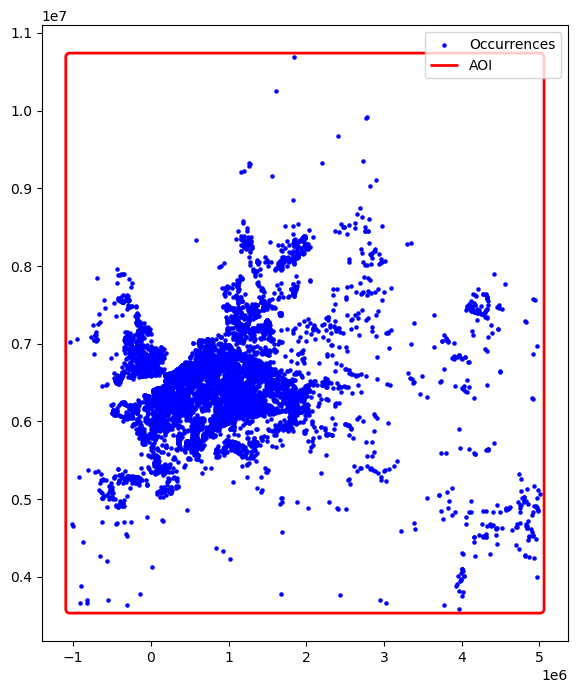

In [15]:
# good code

import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

def make_aoi(gdf, buffer_dist=50000):
    """
    Create AOI = bounding box of data, buffered by distance.
    gdf: GeoDataFrame with occurrence points
    buffer_dist: buffer distance in meters
    """

    # Ensure CRS in meters (for buffer)
    if gdf.crs is None or gdf.crs.is_geographic:
        gdf = gdf.to_crs(epsg=3857)  # Web Mercator

    # Get bounding box polygon
    minx, miny, maxx, maxy = gdf.total_bounds
    bbox = box(minx, miny, maxx, maxy)

    # Convert to GeoSeries and buffer
    aoi = gpd.GeoSeries([bbox], crs=gdf.crs).buffer(buffer_dist)

    return aoi

# Example usage:
# gdf = gpd.read_file("clean_occurrences.shp")  # your species data
aoi = make_aoi(data_thinned, buffer_dist=50000)

# Plot data + AOI outline
fig, ax = plt.subplots(figsize=(8, 8))
data_thinned.plot(ax=ax, color="blue", markersize=5, label="Occurrences")
aoi.boundary.plot(ax=ax, color="red", linewidth=2, label="AOI")
plt.legend()
plt.show()


### Addition of environmental variables

Now, let's add environmental variables to the analysis. You can use environmental variables that are relevant to the ecology of your species, such as temperature, precipitation, elevation, land cover, and terrain. These datasets enable us to comprehensively analyze various factors that may influence the habitat preferences of the species of interest.

The selection of environmental variables in SDM should reflect the habitat preference characteristics of the species. To do this, prior research and literature review on the species' habitat preferences should be conducted. This tutorial primarily focuses on the workflow of SDM , so some in-depth details are omitted.

[**WorldClim V2.1 Bioclim**](https://www.worldclim.org/data/worldclim21.html): This dataset provides 19 bioclimatic variables derived from monthly temperature and precipitation data. It covers the period from 1970 to 2000 and has a resolution of ~1 km2. [**CHELSA-BIOCLIM+**](https://chelsa-climate.org/downloads/) is another option for bioclimatic data.

You are expected to contain all of your environmental variables in one folder, in raster geotiff format. These should have the same structure (extent, resolution).

[**NASA SRTM Digital Elevation 30m**](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003): This dataset contains digital elevation data from the Shuttle Radar Topography Mission (SRTM). The data was primarily collected around the year 2000 and is provided at a resolution of approximately 30 meters (1 arc-second). The following code calculates elevation, slope, aspect, and hillshade layers from the SRTM data.

In [ ]:
# GEE

# NASA SRTM Digital Elevation 30m
terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

[**Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m**](https://developers.google.com/earth-engine/datasets/catalog/NASA_MEASURES_GFCC_TC_v3): The Vegetation Continuous Fields (VCF) dataset from Landsat estimates the proportion of vertically projected vegetation cover when the vegetation height is greater than 5 meters. This dataset is provided for four time periods centered around the years 2000, 2005, 2010, and 2015, with a resolution of 30 meters. Here, the median values from these four time periods are used.

In [ ]:
# GEE

# Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m
tcc = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
median_tcc = (
    tcc.filterDate("2000-01-01", "2015-12-31")
    .select(["tree_canopy_cover"], ["TCC"])
    .median()
)

`bio` (Bioclimatic variables), `terrain` (topography), and `median_tcc` (tree canopy cover) are combined into a single multiband image. The `elevation` band is selected from `terrain`, and a `watermask` is created for locations where `elevation` is greater than `0`. This masks regions below sea level (e.g. the ocean) and prepares the researcher to analyze various environmental factors for the AOI comprehensively.

In [ ]:
# GEE

# Combine bands into a multi-band image
predictors = bio.addBands(terrain).addBands(median_tcc)

# Create a water mask
watermask = terrain.select('elevation').gt(0)

# Mask out ocean pixels and clip to the area of interest
predictors = predictors.updateMask(watermask).clip(aoi)

The following function ensures that all environmental raster layers are restructured according to a reference layer.

In [16]:
def reproject_to_reference(raster, reference):
    """
    Reproject + resample raster to match reference grid.
    """
    return raster.rio.reproject_match(reference)

The following created a stack of environmental variables, reprojected to a common grid.

In [17]:
import glob
import rasterio
import rioxarray
import geopandas as gpd
import xarray as xr

# 1. Load bioclimatic variables (assumes 19 tiffs in a folder)
# bio_files = sorted(glob.glob("../dados_env/*.tif"))  # adjust path
# reference = rioxarray.open_rasterio(bio_files[0])

# Align BIOCLIM variables
# bio_layers = [reproject_to_reference(rioxarray.open_rasterio(f), reference)
#              for f in bio_files]

# Stack them into one xarray dataset
#bio = xr.concat(bio_layers, dim="band")



# Load your rasters with proper names
bio_files = sorted(glob.glob("../dados_env/*.tif"))
reference = rioxarray.open_rasterio(bio_files[0])

bio_layers = []
for i, f in enumerate(bio_files, start=1):
    da = reproject_to_reference(rioxarray.open_rasterio(f, masked=True), reference)

    # If raster has no 'band' dimension, add one
    if "band" not in da.dims:
        da = da.expand_dims(dim={"band": [f"bio{i}"]})
    else:
        da = da.assign_coords(band=[f"bio{i}"])

    bio_layers.append(da.squeeze())

# Concatenate into a stack
bio_stack = xr.concat(bio_layers, dim="band")

# 2. Load terrain and tree cover rasters
# Align terrain & canopy cover
# terrain = reproject_to_reference(rioxarray.open_rasterio("data/terrain.tif"), reference)
# tcc = reproject_to_reference(rioxarray.open_rasterio("data/treecover.tif"), reference)

# Stack into one dataset
# predictors = xr.concat(bio_layers + [terrain, tcc], dim="band")

# 3. Build water mask (elevation > 0)
# Water mask from terrain (ocean = elevation <= 0)
# watermask = terrain > 0
# predictors = predictors.where(watermask)

# Apply mask
# predictors = predictors.where(watermask)

In [18]:
# 4. Clip to AOI polygon
aoi = gpd.read_file("../aoi/aoi.shp").to_crs(reference.rio.crs)   # AOI polygon you made earlier


predictors = bio_stack.rio.clip(aoi.geometry, aoi.crs)

print(predictors)

# save stack predictos
predictors.rio.to_raster("../dados_env/stack/predictors_stack.tif")

<xarray.DataArray (band: 19, y: 1166, x: 1763)> Size: 156MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan,

In [19]:
# convert to crs 4326, the same as env data (aoi)

data_thinned = data_thinned.to_crs(4326)

In [20]:
# Clip data points to the AOI
data_thinned = gpd.clip(data_thinned, aoi)
print("Final data size after AOI clip:", len(data_thinned))

Final data size after AOI clip: 1778


When highly correlated predictor variables are included together in a model, multicollinearity issues can arise. Multicollinearity is a phenomenon that occurs when there are strong linear relationships among independent variables in a model, leading to instability in the estimation of the model's coefficients (weights). This instability can reduce the model's reliability and make predictions or interpretations for new data challenging. Therefore, we will consider multicollinearity and proceed with the process of selecting predictor variables.

First, we will generate 5,000 random points and then extract the predictor variable values of the single multiband image at those points.

In [ ]:
# GEE

# Generate 5,000 random points
data_cor = predictors.sample(scale=grain_size, numPixels=5000, geometries=True)

# Extract predictor variable values
pvals = predictors.sampleRegions(collection=data_cor, scale=grain_size)

In [21]:
# Step 1. Generate random points inside AOI

import geopandas as gpd
import numpy as np
from shapely.geometry import Point

def generate_random_points(aoi_gdf, n_points):
    """
    Generate n_points randomly inside AOI polygon.
    Returns a GeoDataFrame of points.
    """
    points = []
    minx, miny, maxx, maxy = aoi_gdf.total_bounds

    while len(points) < n_points:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        p = Point(x, y)
        if aoi_gdf.geometry.contains(p).any():
            points.append(p)

    gdf_points = gpd.GeoDataFrame(geometry=points, crs=aoi_gdf.crs)
    return gdf_points

# Example usage
n_points = 5000
random_points = generate_random_points(aoi, n_points)

In [22]:
random_points

,geometry
0,POINT (2.56741 48.87478)
1,POINT (1.21548 49.20595)
2,POINT (-0.6666 43.65788)
3,POINT (1.16848 45.56836)
4,POINT (-0.99286 43.71315)
...,...
4995,POINT (-1.39037 46.7942)
4996,POINT (3.71625 49.15564)
4997,POINT (3.62639 50.25332)
4998,POINT (2.19521 42.84157)


In [23]:
import numpy as np
import pandas as pd
import xarray as xr

def extract_raster_values(raster_stack, points_gdf):
    """
    Extract raster values at point locations.
    raster_stack: xarray DataArray with dimension 'band'
    points_gdf: GeoDataFrame with point geometries
    Returns GeoDataFrame with raster values as columns.
    """
    # Ensure CRS match
    points_gdf = points_gdf.to_crs(raster_stack.rio.crs)

    # Collect point coordinates
    xs = [geom.x for geom in points_gdf.geometry]
    ys = [geom.y for geom in points_gdf.geometry]

    # Extract values (n_bands x n_points)
    vals = raster_stack.sel(
        x=xr.DataArray(xs, dims="z"),
        y=xr.DataArray(ys, dims="z"),
        method="nearest"
    ).values

    # Transpose to (n_points x n_bands)
    vals = vals.T

    # Build column names
    if "band" in raster_stack.dims:
        band_names = [str(b) for b in raster_stack["band"].values]
    else:
        band_names = [f"band_{i+1}" for i in range(raster_stack.shape[0])]

    # Merge into GeoDataFrame
    df = points_gdf.copy()
    vals_df = pd.DataFrame(vals, columns=band_names, index=df.index)
    df = pd.concat([df, vals_df], axis=1)

    return df


In [24]:
# Step 2. Extract raster values at those points

# Extract values
pvals = extract_raster_values(predictors, random_points)
print(pvals.head())


                    geometry    bio1    bio2     bio3    bio4   bio5   bio6  \
0   POINT (2.56741 48.87478)  2918.0  2774.0   7084.0   715.0  480.0  127.0   
1   POINT (1.21548 49.20595)  2904.0  2774.0   7159.0   775.0  467.0  145.0   
2   POINT (-0.6666 43.65788)  2938.0  2802.0  11290.0  1304.0  591.0  212.0   
3   POINT (1.16848 45.56836)  2920.0  2778.0  11427.0  1143.0  734.0  144.0   
4  POINT (-0.99286 43.71315)  2940.0  2810.0  11541.0  1404.0  602.0  233.0   

     bio7    bio8    bio9   bio10   bio11  bio12  bio13   bio14   bio15  \
0  1954.0  1543.0  1819.0  1741.0  2844.0   76.0   3.37  5582.0  2969.0   
1  2127.0  1588.0  1590.0  1906.0  2837.0   74.0   3.47  5072.0  2954.0   
2  3497.0  1987.0  1987.0  3105.0  2870.0   92.0   3.88  5332.0  2995.0   
3  3342.0  2346.0  2363.0  3095.0  2847.0   75.0   3.34  5516.0  2971.0   
4  3789.0  2014.0  2014.0  3189.0  2874.0   90.0   3.91  5112.0  2996.0   

    bio16  bio17   bio18   bio19  
0  2743.0  226.0  2901.0  2805.0  
1  2

We will convert the extracted predictor values for each point into a DataFrame and then check the first row.

In [25]:
pvals = extract_raster_values(predictors, random_points)
print(pvals.shape)   # should be (5000, 19 + 1 geometry col)
print(pvals.head())

(5000, 20)
                    geometry    bio1    bio2     bio3    bio4   bio5   bio6  \
0   POINT (2.56741 48.87478)  2918.0  2774.0   7084.0   715.0  480.0  127.0   
1   POINT (1.21548 49.20595)  2904.0  2774.0   7159.0   775.0  467.0  145.0   
2   POINT (-0.6666 43.65788)  2938.0  2802.0  11290.0  1304.0  591.0  212.0   
3   POINT (1.16848 45.56836)  2920.0  2778.0  11427.0  1143.0  734.0  144.0   
4  POINT (-0.99286 43.71315)  2940.0  2810.0  11541.0  1404.0  602.0  233.0   

     bio7    bio8    bio9   bio10   bio11  bio12  bio13   bio14   bio15  \
0  1954.0  1543.0  1819.0  1741.0  2844.0   76.0   3.37  5582.0  2969.0   
1  2127.0  1588.0  1590.0  1906.0  2837.0   74.0   3.47  5072.0  2954.0   
2  3497.0  1987.0  1987.0  3105.0  2870.0   92.0   3.88  5332.0  2995.0   
3  3342.0  2346.0  2363.0  3095.0  2847.0   75.0   3.34  5516.0  2971.0   
4  3789.0  2014.0  2014.0  3189.0  2874.0   90.0   3.91  5112.0  2996.0   

    bio16  bio17   bio18   bio19  
0  2743.0  226.0  2901.0  28

In [26]:
# Extract values (GeoDataFrame)
pvals_gdf = extract_raster_values(predictors, random_points)

# Convert to Pandas DataFrame (drop geometry)
pvals_df = pvals_gdf.drop(columns="geometry")

# Check first row
print(pvals_df.head(1))


     bio1    bio2    bio3   bio4   bio5   bio6    bio7    bio8    bio9  \
0  2918.0  2774.0  7084.0  715.0  480.0  127.0  1954.0  1543.0  1819.0   

    bio10   bio11  bio12  bio13   bio14   bio15   bio16  bio17   bio18   bio19  
0  1741.0  2844.0   76.0   3.37  5582.0  2969.0  2743.0  226.0  2901.0  2805.0  


In [27]:
# Displaying the columns
columns = pvals_df.columns
print(columns)

Index(['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9',
       'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17',
       'bio18', 'bio19'],
      dtype='object')


Calculating Spearman correlation coefficients between the given predictor variables and visualizing them in a heatmap.

In [28]:
def plot_correlation_heatmap(dataframe, h_size=10, show_labels=False):
    # Calculate Spearman correlation coefficients
    correlation_matrix = dataframe.corr(method="spearman")

    # Create a heatmap
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # Optionally display values on the heatmap
    if show_labels:
        for i in range(correlation_matrix.shape[0]):
            for j in range(correlation_matrix.shape[1]):
                plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                         ha='center', va='center', color='white', fontsize=8)

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables Correlation Matrix")
    plt.colorbar(label="Spearman Correlation")
    plt.savefig('correlation_heatmap_plot.png')
    plt.show()

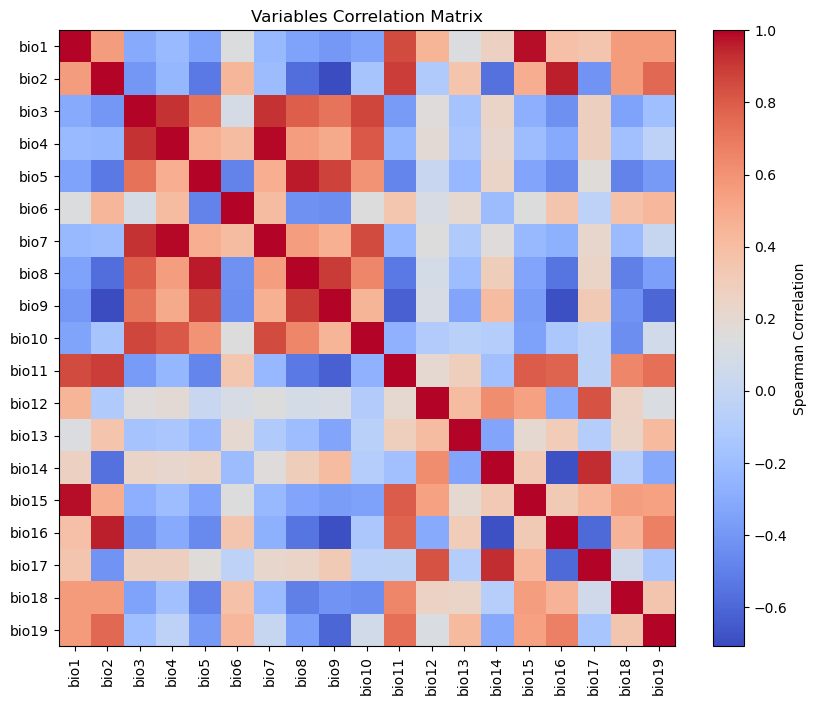

In [29]:
# Plot the correlation heatmap of variables
plot_correlation_heatmap(pvals_df)

Spearman correlation coefficient is useful for understanding the general associations among predictor variables but does not directly assess how multiple variables interact, specifically detecting multicollinearity.

The **Variance Inflation Factor (VIF below)** is a statistical metric used to evaluate multicollinearity and guide variable selection. It indicates the degree of linear relationship of each independent variable with the other independent variables, and high VIF values can be evidence of multicollinearity.

Typically, when VIF values exceed 5 or 10, it suggests that the variable has a strong correlation with other variables, potentially compromising the stability and interpretability of the model. In this tutorial, a criterion of VIF values less than 10 was used for variable selection. The following 6 variables were selected based on VIF.

In [30]:
pvals_df

,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,2918.0,2774.0,7084.0,715.0,480.0,127.0,1954.0,1543.0,1819.0,1741.0,2844.0,76.0,3.37,5582.0,2969.0,2743.0,226.0,2901.0,2805.0
1,2904.0,2774.0,7159.0,775.0,467.0,145.0,2127.0,1588.0,1590.0,1906.0,2837.0,74.0,3.47,5072.0,2954.0,2742.0,212.0,2808.0,2800.0
2,2938.0,2802.0,11290.0,1304.0,591.0,212.0,3497.0,1987.0,1987.0,3105.0,2870.0,92.0,3.88,5332.0,2995.0,2757.0,238.0,2838.0,2938.0
3,2920.0,2778.0,11427.0,1143.0,734.0,144.0,3342.0,2346.0,2363.0,3095.0,2847.0,75.0,3.34,5516.0,2971.0,2747.0,224.0,2786.0,2915.0
4,2940.0,2810.0,11541.0,1404.0,602.0,233.0,3789.0,2014.0,2014.0,3189.0,2874.0,90.0,3.91,5112.0,2996.0,2767.0,229.0,2844.0,2940.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2918.0,2790.0,9054.0,1084.0,463.0,277.0,3129.0,1478.0,1478.0,2698.0,2852.0,76.0,3.60,4982.0,2969.0,2757.0,212.0,2824.0,2918.0
4996,2910.0,2765.0,7538.0,753.0,512.0,123.0,2019.0,1643.0,2011.0,1927.0,2836.0,74.0,3.27,5611.0,2960.0,2735.0,225.0,2802.0,2797.0
4997,2902.0,2766.0,8481.0,810.0,545.0,109.0,2336.0,1843.0,2208.0,2129.0,2833.0,72.0,3.34,5282.0,2951.0,2736.0,215.0,2802.0,2795.0
4998,2925.0,2783.0,9626.0,1031.0,494.0,194.0,2783.0,1803.0,1803.0,2649.0,2852.0,83.0,3.52,5507.0,2977.0,2741.0,236.0,2841.0,2925.0


In [31]:
# Filter variables based on Variance Inflation Factor (VIF)
def filter_variables_by_vif(dataframe, threshold=200):

    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]

    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [
            variance_inflation_factor(vif_data.values, i)
            for i in range(vif_data.shape[1])
        ]

        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)

        if max_vif < threshold:
            break

        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")

        del remaining_columns[max_vif_index]

    filtered_data = dataframe[remaining_columns]
    bands = filtered_data.columns.tolist()
    print("Bands:", bands)

    return filtered_data, bands

In [32]:
# Step 1. Check for NaN and Inf
import numpy as np

print("NaN count per column:")
print(pvals_df.isna().sum())

print("\nInf count per column:")
print(np.isinf(pvals_df).sum())


NaN count per column:
bio1     20
bio2     20
bio3      5
bio4      5
bio5      5
bio6      5
bio7     20
bio8     20
bio9     20
bio10    20
bio11     5
bio12     5
bio13    20
bio14     5
bio15     5
bio16     5
bio17     5
bio18    20
bio19    20
dtype: int64

Inf count per column:
bio1     0
bio2     0
bio3     0
bio4     0
bio5     0
bio6     0
bio7     0
bio8     0
bio9     0
bio10    0
bio11    0
bio12    0
bio13    0
bio14    0
bio15    0
bio16    0
bio17    0
bio18    0
bio19    0
dtype: int64


In [33]:
# Step 2. Remove problematic rows
df_clean = pvals_df.replace([np.inf, -np.inf], np.nan).dropna()
print("Original shape:", pvals_df.shape)
print("Clean shape:", df_clean.shape)


Original shape: (5000, 19)
Clean shape: (4980, 19)


In [34]:
filtered_pvals_df, bands = filter_variables_by_vif(df_clean)

Removing 'bio16' with VIF 474312906.83
Removing 'bio1' with VIF 42733079.83
Removing 'bio2' with VIF 17127273.69
Removing 'bio15' with VIF 1230048.36
Removing 'bio11' with VIF 29590.54
Removing 'bio17' with VIF 23388.43
Removing 'bio18' with VIF 7476.32
Removing 'bio3' with VIF 2753.28
Removing 'bio19' with VIF 2076.13
Removing 'bio7' with VIF 1347.74
Removing 'bio8' with VIF 899.57
Removing 'bio12' with VIF 218.37
Bands: ['bio4', 'bio5', 'bio6', 'bio9', 'bio10', 'bio13', 'bio14']


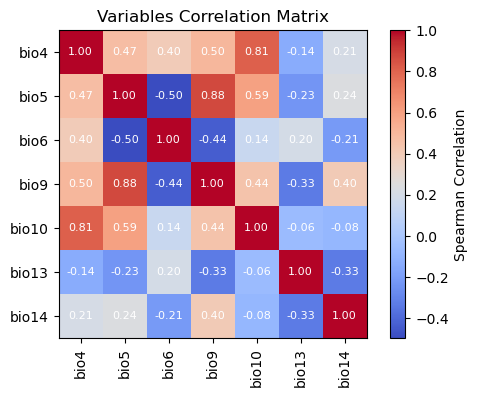

In [35]:
# Variable Selection Based on VIF
predictors = predictors.sel(band=bands)

# Plot the correlation heatmap of variables
plot_correlation_heatmap(filtered_pvals_df, h_size=6, show_labels=True)

Next, let's visualize the 6 selected predictor variables on the map.
![Predictor Variables for Analysis](predictor_variables.png)

You can explore the available palettes for map visualization using the following code. For example, the `terrain` palette looks like this.
```
cm.plot_colormaps(width=8.0, height=0.2)
```

### Generation of pseudo-absence data

In the process of SDM, the selection of input data for a species is mainly approached using two methods:

1. **Presence-Background Method**: This method compares the locations where a particular species has been observed (presence) with other locations where the species has not been observed (background). Here, the background data does not necessarily mean areas where the species does not exist but rather is set up to reflect the overall environmental conditions of the study area. It is used to distinguish suitable environments where the species could exist from less suitable ones.

2. **Presence-Absence Method**: This method compares locations where the species has been observed (presence) with locations where it has definitively not been observed (absence). Here, absence data represents specific locations where the species is known not to exist. It does not reflect the overall environmental conditions of the study area but rather points to locations where the species is estimated not to exist.

In practice, it is often difficult to collect true absence data, so pseudo-absence data generated artificially is frequently used. However, it's important to acknowledge the limitations and potential errors of this method, as artificially generated pseudo-absence points may not accurately reflect true absence areas.

The choice between these two methods depends on data availability, research objectives, model accuracy and reliability, as well as time and resources. Here, we will use occurrence data collected from GBIF and artificially generated pseudo-absence data to model using the "Presence-Absence" method.

The generation of pseudo-absence data will be done through the "environmental profiling approach", and the specific steps are as follows:

1. Environmental Classification Using k-means Clustering: The k-means clustering algorithm, based on Euclidean distance, will be used to divide the pixels within the study area into two clusters. One cluster will represent areas with similar environmental characteristics to randomly selected 100 presence locations, while the other cluster will represent areas with different characteristics.

2. Generation of Pseudo-Absence Data within Dissimilar Clusters: Within the second cluster identified in the first step (which has different environmental characteristics from the presence data), randomly generated pseudo-absence points will be created. These pseudo-absence points will represent locations where the species is not expected to exist.

In [36]:
predictors.shape

(7, 1166, 1763)

In [ ]:
# GEE
# Randomly select 100 locations for occurrence
pvals = predictors.sampleRegions(
    collection=data.randomColumn().sort('random').limit(100),
    properties=[],
    scale=grain_size
)

# Perform k-means clustering
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(pvals)

cl_result = predictors.cluster(clusterer)

# Get cluster ID for locations similar to occurrence
cl_id = cl_result.sampleRegions(
    collection=data.randomColumn().sort('random').limit(200),
    properties=[],
    scale=grain_size
)

# Define non-occurrence areas in dissimilar clusters
cl_id = ee.FeatureCollection(cl_id).reduceColumns(ee.Reducer.mode(),['cluster'])
cl_id = ee.Number(cl_id.get('mode')).subtract(1).abs()
cl_mask = cl_result.select(['cluster']).eq(cl_id)

In [37]:
data_thinned.head()

,species,year,month,geometry
8641,TriticumAestivum,2016,6,POINT (-0.91452 43.13028)
8534,TriticumAestivum,2012,9,POINT (-0.17775 43.49566)
2548,TriticumAestivum,1993,11,POINT (-1.14198 43.56036)
7953,TriticumAestivum,2020,12,POINT (-0.30652 43.62208)
1150,TriticumAestivum,1980,5,POINT (0.51772 43.08925)


In [38]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from scipy.stats import mode
import xarray as xr

# -----------------------------
# 1. Prepare presence data
# -----------------------------
# Make sure presence data is a GeoDataFrame
presence = data_thinned[['geometry']].copy()
presence = presence.set_geometry("geometry")
presence = presence.to_crs(predictors.rio.crs)

# Randomly select 100 presence points
presence_sample = presence.sample(n=100, random_state=42)

# Extract environmental values for presence points
presence_vals = extract_raster_values(predictors, presence_sample)
X_train = presence_vals.drop(columns="geometry").values

# Drop NaN values from X_train

if isinstance(X_train, pd.DataFrame):
    X_train = X_train.dropna()
else:
    # If X_train is a numpy array, convert to DataFrame, dropna, then back to array
    X_train = pd.DataFrame(X_train).dropna().values

# -----------------------------
# 2. Fit k-means with 2 clusters
# -----------------------------
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_train)

# Assign cluster IDs to presence points
presence_clusters = kmeans.predict(X_train)

# Find majority cluster = presence cluster
presence_cluster = mode(presence_clusters, keepdims=False).mode
absence_cluster = 1 - presence_cluster

# -----------------------------
# 3. Cluster entire predictor raster
# -----------------------------
arr = predictors.values  # shape (bands, y, x)
n_bands, ny, nx = arr.shape
arr_2d = arr.reshape(n_bands, -1).T  # (n_pixels, n_bands)

# Mask NaN pixels
mask = np.any(np.isnan(arr_2d), axis=1)
valid_pixels = arr_2d[~mask]

# Predict cluster for valid pixels
clusters = np.full(arr_2d.shape[0], fill_value=-1)
clusters[~mask] = kmeans.predict(valid_pixels)

# Reshape back to raster grid
cluster_raster = clusters.reshape(ny, nx)

# Wrap as DataArray
cl_result = xr.DataArray(
    cluster_raster,
    coords={"y": predictors.y, "x": predictors.x},
    dims=("y", "x"),
    name="cluster"
)

# -----------------------------
# 4. Generate pseudo-absence points from "absence cluster"
# -----------------------------
# Get coordinates of pixels in the absence cluster
ys, xs = np.where(cluster_raster == absence_cluster)

# Convert raster indices to coordinates
xs_coords = predictors.x.values[xs]
ys_coords = predictors.y.values[ys]

coords = list(zip(xs_coords, ys_coords))

# Choose N random pseudo-absence points
n_pseudo = 5000  # for example
rng = np.random.default_rng(42)
sample_idx = rng.choice(len(coords), size=n_pseudo, replace=False)
pseudo_coords = [coords[i] for i in sample_idx]

# Convert to GeoDataFrame
pseudo_absence = gpd.GeoDataFrame(
    {
        "species": ["pseudo_absence"] * len(pseudo_coords)  # repeat label for all rows
    },
    geometry=[Point(x, y) for x, y in pseudo_coords],
    crs=predictors.rio.crs
)

# -----------------------------
# 5. Combine presence + pseudo-absence if needed
# -----------------------------
combined = gpd.GeoDataFrame(
    pd.concat([presence.assign(pa=1), pseudo_absence.assign(pa=0)]),
    crs=predictors.rio.crs
)

print("Presence points:", presence.shape[0])
print("Pseudo-absence points:", pseudo_absence.shape[0])

Presence points: 1778
Pseudo-absence points: 5000


<Axes: >

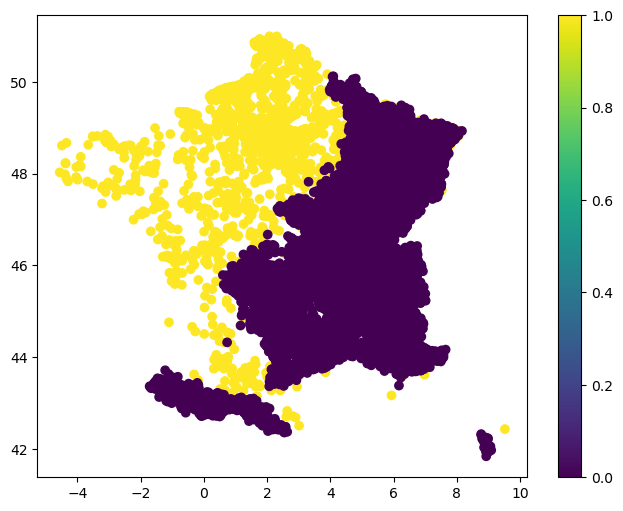

In [39]:
combined.plot(column="pa", legend=True, figsize=(8, 6))

### Model fitting and prediction

We will now divide the data into training data and test data. The training data will be used to find the optimal parameters by training the model, while the test data will be used to evaluate the model trained beforehand. An important concept to consider in this context is spatial autocorrelation.

**Spatial autocorrelation** is an essential element in SDM, associated with Tobler's law. It embodies the concept that "everything is related to everything else, but near things are more related than distant things". Spatial autocorrelation represents the significant relationship between the location of species and environmental variables. However, if spatial autocorrelation exists between the training and test data, the independence between the two data sets can be compromised. This significantly impacts the evaluation of the model's generalization ability.

One method to address this issue is the spatial block cross-validation technique, which involves dividing the data into training and testing datasets. This technique involves dividing the data into multiple blocks, using each block independently as training and test datasets to reduce the impact of spatial autocorrelation. This enhances the independence between datasets, allowing for a more accurate evaluation of the model's generalization ability.

The specific procedure is as follows:
1. Creation of spatial blocks: Divide the entire dataset into spatial blocks of equal size (e.g., 50x50 km).
2. Assignment of training and testing sets: Each spatial block is randomly assigned to either the training set (70%) or the test set (30%). This prevents the model from overfitting to data from specific areas and aims to achieve more generalized results.
3. Iterative cross-validation: The entire process is repeated n times (e.g., 10 times). In each iteration, the blocks are randomly divided into training and test sets again, which is intended to improve the model's stability and reliability.
4. Generation of pseudo-absence data: In each iteration, pseudo-absence data are randomly generated to evaluate the model's performance.

In [ ]:
# GEE

Scale = 50000
grid = watermask.reduceRegions(
    collection=aoi.coveringGrid(scale=Scale, proj='EPSG:4326'),
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.addLayer(grid, {}, "Grid for spatial block cross validation")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(aoi, 6)
Map

In [40]:
import numpy as np
import geopandas as gpd
from shapely.geometry import box, Point

# ----------------------------------------
# 1. Create spatial blocks (e.g., 50x50 km)
# ----------------------------------------
def create_spatial_blocks(gdf, block_size_km=50):
    """
    Divide study area into equal-sized spatial blocks.
    Returns a GeoDataFrame of blocks.
    """
    # Convert block size to CRS units (assumes meters if projected CRS)
    block_size = block_size_km * 1000  
    
    # Get extent of data
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    minx, miny, maxx, maxy = bounds

    # Build grid
    x_coords = np.arange(minx, maxx, block_size)
    y_coords = np.arange(miny, maxy, block_size)

    polygons = []
    ids = []
    for i, x in enumerate(x_coords):
        for j, y in enumerate(y_coords):
            polygons.append(box(x, y, x + block_size, y + block_size))
            ids.append(f"block_{i}_{j}")

    blocks = gpd.GeoDataFrame({"block_id": ids}, geometry=polygons, crs=gdf.crs)
    return blocks

# ----------------------------------------
# 2. Assign train/test blocks
# ----------------------------------------
def assign_blocks(blocks, train_frac=0.7, random_state=None):
    rng = np.random.default_rng(random_state)
    block_ids = blocks["block_id"].values
    rng.shuffle(block_ids)

    n_train = int(len(block_ids) * train_frac)
    train_blocks = block_ids[:n_train]
    test_blocks = block_ids[n_train:]

    return train_blocks, test_blocks


In [ ]:
# bad code

# ----------------------------------------
# 3. Cross-validation iterations
# ----------------------------------------
def spatial_block_cv(presence_gdf, blocks, predictors, n_iter=10, n_pseudo=500, train_frac=0.7):
    results = []
    for i in range(n_iter):
        print(f"Iteration {i+1}/{n_iter}")

        # Assign blocks randomly
        train_blocks, test_blocks = assign_blocks(blocks, train_frac=train_frac, random_state=i)

        # Assign presences to blocks by spatial join
        presence_with_blocks = gpd.sjoin(presence_gdf, blocks, how="left", predicate="within")

        # Split by block assignment
        train_presence = presence_with_blocks[presence_with_blocks["block_id"].isin(train_blocks)]
        test_presence  = presence_with_blocks[presence_with_blocks["block_id"].isin(test_blocks)]


        # Generate pseudo-absences from test blocks
        test_extent = blocks.loc[blocks.block_id.isin(test_blocks)].unary_union
        ys, xs = np.where(~np.isnan(predictors.isel(band=0).values))  # valid pixels
        x_coords = predictors.x.values[xs]
        y_coords = predictors.y.values[ys]
        coords = [Point(x, y) for x, y in zip(x_coords, y_coords) if test_extent.contains(Point(x, y))]

        rng = np.random.default_rng(i)
        sample_idx = rng.choice(len(coords), size=min(n_pseudo, len(coords)), replace=False)
        pseudo_absence = gpd.GeoDataFrame({"species": "pseudo_absence"}, geometry=[coords[j] for j in sample_idx], crs=predictors.rio.crs)

        # Store iteration results
        results.append({
            "iteration": i+1,
            "train_presence": train_presence,
            "test_presence": test_presence,
            "pseudo_absence": pseudo_absence,
            "train_blocks": train_blocks,
            "test_blocks": test_blocks
        })
    return results


In [ ]:
# bad code

# ----------------------------------------
# 3. Cross-validation iterations
# ----------------------------------------
def spatial_block_cv(presence_gdf, blocks, predictors, n_iter=10, n_pseudo=500, train_frac=0.7):
    results = []
    for i in range(n_iter):
        print(f"Iteration {i+1}/{n_iter}")

        # Assign blocks randomly
        train_blocks, test_blocks = assign_blocks(blocks, train_frac=train_frac, random_state=i)

        # Subset presences
        train_presence = presence_gdf[presence_gdf.sindex.query_bulk(blocks.loc[blocks.block_id.isin(train_blocks)].geometry, predicate="intersects")[1]]
        test_presence  = presence_gdf[presence_gdf.sindex.query_bulk(blocks.loc[blocks.block_id.isin(test_blocks)].geometry, predicate="intersects")[1]]

        # Generate pseudo-absences from test blocks
        test_extent = blocks.loc[blocks.block_id.isin(test_blocks)].unary_union
        ys, xs = np.where(~np.isnan(predictors.isel(band=0).values))  # valid pixels
        x_coords = predictors.x.values[xs]
        y_coords = predictors.y.values[ys]
        coords = [Point(x, y) for x, y in zip(x_coords, y_coords) if test_extent.contains(Point(x, y))]

        rng = np.random.default_rng(i)
        sample_idx = rng.choice(len(coords), size=min(n_pseudo, len(coords)), replace=False)
        pseudo_absence = gpd.GeoDataFrame({"species": "pseudo_absence"}, geometry=[coords[j] for j in sample_idx], crs=predictors.rio.crs)

        # Store iteration results
        results.append({
            "iteration": i+1,
            "train_presence": train_presence,
            "test_presence": test_presence,
            "pseudo_absence": pseudo_absence,
            "train_blocks": train_blocks,
            "test_blocks": test_blocks
        })
    return results


In [41]:
# good code

# ----------------------------------------
# 3. Cross-validation iterations
# ----------------------------------------

import geopandas as gpd
import numpy as np
import random
from shapely.geometry import box

def spatial_block_cv(presence_gdf, pseudoabsence_gdf, block_size=50000, n_iterations=10, train_frac=0.7):
    """
    Spatial block cross-validation for species distribution modeling.

    Parameters
    ----------
    presence_gdf : GeoDataFrame
        Presence points (must have geometry column).
    pseudoabsence_gdf : GeoDataFrame
        Pseudo-absence points (must have geometry column).
    block_size : int
        Size of blocks in meters (default 50 km).
    n_iterations : int
        Number of cross-validation iterations.
    train_frac : float
        Fraction of blocks to use for training (default 0.7).

    Returns
    -------
    splits : list of dict
        Each entry has train/test presence and pseudo-absence sets.
    """

    # Work in projected CRS (meters)
    crs_original = presence_gdf.crs
    if crs_original is None:
        raise ValueError("Presence data must have a CRS defined")

    presence_proj = presence_gdf.to_crs(epsg=3857)
    pseudoabsence_proj = pseudoabsence_gdf.to_crs(epsg=3857)

    # Build grid of blocks covering the study area
    bounds = presence_proj.total_bounds  # (minx, miny, maxx, maxy)
    x_coords = np.arange(bounds[0], bounds[2] + block_size, block_size)
    y_coords = np.arange(bounds[1], bounds[3] + block_size, block_size)

    polygons = []
    ids = []
    bid = 0
    for x in x_coords[:-1]:
        for y in y_coords[:-1]:
            polygons.append(box(x, y, x + block_size, y + block_size))
            ids.append(bid)
            bid += 1
    blocks = gpd.GeoDataFrame({"block_id": ids}, geometry=polygons, crs=presence_proj.crs)

    splits = []

    for i in range(n_iterations):
        # Randomly split blocks into train/test
        block_ids = blocks["block_id"].unique()
        np.random.shuffle(block_ids)
        n_train = int(len(block_ids) * train_frac)
        train_blocks = block_ids[:n_train]
        test_blocks = block_ids[n_train:]

        # Assign presence points to blocks
        presence_with_blocks = gpd.sjoin(presence_proj, blocks, how="left", predicate="within")
        pseudo_with_blocks = gpd.sjoin(pseudoabsence_proj, blocks, how="left", predicate="within")

        train_presence = presence_with_blocks[presence_with_blocks["block_id"].isin(train_blocks)]
        test_presence  = presence_with_blocks[presence_with_blocks["block_id"].isin(test_blocks)]

        train_absence = pseudo_with_blocks[pseudo_with_blocks["block_id"].isin(train_blocks)]
        test_absence  = pseudo_with_blocks[pseudo_with_blocks["block_id"].isin(test_blocks)]

        # Convert back to original CRS
        train_presence = train_presence.to_crs(crs_original)
        test_presence  = test_presence.to_crs(crs_original)
        train_absence  = train_absence.to_crs(crs_original)
        test_absence   = test_absence.to_crs(crs_original)

        splits.append({
            "iteration": i + 1,
            "train_presence": train_presence,
            "test_presence": test_presence,
            "train_absence": train_absence,
            "test_absence": test_absence
        })

    return splits


In [42]:
# Make sure presence data is projected in meters (e.g., UTM)
presence_proj = data_thinned.to_crs("EPSG:32630")  # pick UTM zone for study area

# Create 50x50 km blocks
blocks = create_spatial_blocks(presence_proj, block_size_km=50)

# Run 10-fold spatial block CV
# cv_results = spatial_block_cv(presence_proj, blocks, predictors, n_iter=10, n_pseudo=1000)
cv_results = spatial_block_cv(
    presence_proj,           # presence GeoDataFrame
    pseudo_absence,       # pseudo-absence GeoDataFrame
    block_size=50000,        # 50 km blocks
    n_iterations=10,         # number of CV folds
    train_frac=0.7           # 70/30 split
)


# Access results of 1st iteration
iter1 = cv_results[0]
print("Train presences:", len(iter1["train_presence"]))
print("Test presences:", len(iter1["test_presence"]))
print("Train-absences:", len(iter1["train_absence"]))
print("Test-absences:", len(iter1["test_absence"]))


Train presences: 1221
Test presences: 555
Train-absences: 3528
Test-absences: 1440


Now we can fit the model. Fitting a model involves understanding the patterns in the data and adjusting the model's parameters (weights and biases) accordingly. This process enables the model to make more accurate predictions when presented with new data. For this purpose, we have defined a function called SDM() to fit the model.

We will use the **Random Forest** algorithm.

In [ ]:
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio import mask
from shapely.geometry import box
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import random
import xarray as xr
from rasterio.features import geometry_mask

def sdm_local(seed, presence_gdf, predictors, aoi_gdf, grain_size=1000, split=0.7, n_trees=500, bands=None):
    """
    Local equivalent of the GEE sdm() function for species distribution modeling.
    
    Parameters
    ----------
    seed : int
        Random seed for reproducibility.
    presence_gdf : GeoDataFrame
        Presence points (must have geometry column).
    predictors : xarray.DataArray
        Environmental predictor stack (shape: [n_vars, height, width]).
    aoi_gdf : GeoDataFrame
        Area of interest polygon(s).
    grain_size : int
        Approximate resolution (meters).
    split : float
        Fraction of data to use for training (default=0.7).
    n_trees : int
        Number of trees for Random Forest.
    bands : list of str
        List of predictor band names (optional).
    
    Returns
    -------
    dict with:
        - 'probability_raster': numpy array of habitat suitability
        - 'binary_raster': numpy array of binary presence/absence
        - 'train_points': GeoDataFrame with PresAbs=1 or 0
        - 'test_points': GeoDataFrame with PresAbs=1 or 0
        - 'importance': dict of variable importance
    """
    np.random.seed(seed)
    random.seed(seed)

    # --- 1. TRAIN/TEST SPLIT BY RANDOM BLOCKS ---
    bounds = presence_gdf.total_bounds
    block_size = grain_size * 50  # e.g., 50x50 pixels ~ 50km if grain_size=1000
    x_coords = np.arange(bounds[0], bounds[2] + block_size, block_size)
    y_coords = np.arange(bounds[1], bounds[3] + block_size, block_size)

    blocks = []
    bid = 0
    for x in x_coords[:-1]:
        for y in y_coords[:-1]:
            blocks.append({"block_id": bid, "geometry": box(x, y, x + block_size, y + block_size)})
            bid += 1
    grid = gpd.GeoDataFrame(blocks, crs=presence_gdf.crs)

    grid["random"] = np.random.rand(len(grid))
    train_blocks = grid[grid["random"] < split]
    test_blocks = grid[grid["random"] >= split]

    # Assign points to blocks
    presence_with_blocks = gpd.sjoin(presence_gdf, grid, how="left", predicate="within")
    tr_presence = presence_with_blocks[presence_with_blocks["block_id"].isin(train_blocks["block_id"])]
    te_presence = presence_with_blocks[presence_with_blocks["block_id"].isin(test_blocks["block_id"])]

    tr_presence["PresAbs"] = 1
    te_presence["PresAbs"] = 1

    # --- 2. GENERATE PSEUDO-ABSENCE POINTS ---
    def generate_pseudo_absence(n_points, region_gdf, existing_gdf):
        minx, miny, maxx, maxy = region_gdf.total_bounds
        points = []
        while len(points) < n_points:
            x = np.random.uniform(minx, maxx)
            y = np.random.uniform(miny, maxy)
            p = Point(x, y)
            if not existing_gdf.geometry.contains(p).any():
                points.append({"geometry": p, "PresAbs": 0})
        return gpd.GeoDataFrame(points, geometry="geometry", crs=region_gdf.crs)

    tr_pseudo = generate_pseudo_absence(len(tr_presence), train_blocks, tr_presence)
    te_pseudo = generate_pseudo_absence(len(te_presence), test_blocks, te_presence)

    # Merge train/test sets
    train_all = pd.concat([tr_presence, tr_pseudo])
    test_all  = pd.concat([te_presence, te_pseudo])

    # --- 3. EXTRACT ENVIRONMENTAL VALUES ---
    def extract_predictor_values(gdf, predictors):
        coords = [(geom.x, geom.y) for geom in gdf.geometry]
        vals = [predictors.sel(x=x, y=y, method="nearest").values for x, y in coords]
        df = pd.DataFrame(vals, columns=predictors.coords["band"].values if "band" in predictors.coords else bands)
        df["PresAbs"] = gdf["PresAbs"].values
        return df


    train_df = extract_predictor_values(train_all, predictors)
    test_df  = extract_predictor_values(test_all, predictors)

    X_train = train_df.drop(columns="PresAbs")
    y_train = train_df["PresAbs"]
    X_test  = test_df.drop(columns="PresAbs")
    y_test  = test_df["PresAbs"]

    # --- 4. TRAIN RANDOM FOREST ---
    rf = RandomForestClassifier(
        n_estimators=n_trees,
        min_samples_leaf=10,
        max_features="sqrt",
        random_state=seed,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- 5. PREDICT SUITABILITY MAP ---
    flat_data = predictors.stack(z=("y", "x")).transpose("band", "z").values.T
    prob_pred = rf.predict_proba(flat_data)[:, 1].reshape(predictors.shape[1], predictors.shape[2])
    bin_pred  = (prob_pred > 0.5).astype(np.uint8)

    importance = dict(zip(X_train.columns, rf.feature_importances_))

    return {
        "probability_raster": prob_pred,
        "binary_raster": bin_pred,
        "train_points": train_all,
        "test_points": test_all,
        "importance": importance
    }


In [55]:
print(data_thinned.head())
print(data_thinned.dtypes)
print(data_thinned.geometry.name if hasattr(data_thinned, "geometry") else "No geometry column")


               species  year  month                   geometry
8641  TriticumAestivum  2016      6  POINT (-0.91452 43.13028)
8534  TriticumAestivum  2012      9  POINT (-0.17775 43.49566)
2548  TriticumAestivum  1993     11  POINT (-1.14198 43.56036)
7953  TriticumAestivum  2020     12  POINT (-0.30652 43.62208)
1150  TriticumAestivum  1980      5   POINT (0.51772 43.08925)
species       object
year           int64
month          int64
geometry    geometry
dtype: object
geometry


In [61]:
result = sdm_local(
    seed=42,
    presence_gdf=data_thinned,
    predictors=predictors,
    aoi_gdf=aoi,
    grain_size=1000,
    bands=list(predictors.coords["band"].values)
)


/usr/local/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


ValueError: Unknown column geometry

In [ ]:
# GEE

def sdm(x):
    seed = ee.Number(x)

    # Random block division for training and validation
    rand_blk = ee.FeatureCollection(grid).randomColumn(seed=seed).sort("random")
    training_grid = rand_blk.filter(ee.Filter.lt("random", split))  # Grid for training
    testing_grid = rand_blk.filter(ee.Filter.gte("random", split))  # Grid for testing

    # Presence points
    presence_points = ee.FeatureCollection(data)
    presence_points = presence_points.map(lambda feature: feature.set("PresAbs", 1))
    tr_presence_points = presence_points.filter(
        ee.Filter.bounds(training_grid)
    )  # Presence points for training
    te_presence_points = presence_points.filter(
        ee.Filter.bounds(testing_grid)
    )  # Presence points for testing

    # Pseudo-absence points for training
    tr_pseudo_abs_points = area_for_pa.sample(
        region=training_grid,
        scale=grain_size,
        numPixels=tr_presence_points.size().add(300),
        seed=seed,
        geometries=True,
    )
    # Same number of pseudo-absence points as presence points for training
    tr_pseudo_abs_points = (
        tr_pseudo_abs_points.randomColumn()
        .sort("random")
        .limit(ee.Number(tr_presence_points.size()))
    )
    tr_pseudo_abs_points = tr_pseudo_abs_points.map(lambda feature: feature.set("PresAbs", 0))

    te_pseudo_abs_points = area_for_pa.sample(
        region=testing_grid,
        scale=grain_size,
        numPixels=te_presence_points.size().add(100),
        seed=seed,
        geometries=True,
    )
    # Same number of pseudo-absence points as presence points for testing
    te_pseudo_abs_points = (
        te_pseudo_abs_points.randomColumn()
        .sort("random")
        .limit(ee.Number(te_presence_points.size()))
    )
    te_pseudo_abs_points = te_pseudo_abs_points.map(lambda feature: feature.set("PresAbs", 0))

    # Merge training and pseudo-absence points
    training_partition = tr_presence_points.merge(tr_pseudo_abs_points)
    testing_partition = te_presence_points.merge(te_pseudo_abs_points)

    # Extract predictor variable values at training points
    train_pvals = predictors.sampleRegions(
        collection=training_partition,
        properties=["PresAbs"],
        scale=grain_size,
        geometries=True,
    )

    # Random Forest classifier
    classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=500,
        variablesPerSplit=None,
        minLeafPopulation=10,
        bagFraction=0.5,
        maxNodes=None,
        seed=seed,
    )
    # Presence probability: Habitat suitability map
    classifier_pr = classifier.setOutputMode("PROBABILITY").train(
        train_pvals, "PresAbs", bands
    )
    classified_img_pr = predictors.select(bands).classify(classifier_pr)

    # Binary presence/absence map: Potential distribution map
    classifier_bin = classifier.setOutputMode("CLASSIFICATION").train(
        train_pvals, "PresAbs", bands
    )
    classified_img_bin = predictors.select(bands).classify(classifier_bin)

    return [
        classified_img_pr,
        classified_img_bin,
        training_partition,
        testing_partition,
    ], classifier_pr

Spatial blocks are divided into 70% for model training and 30% for model testing, respectively. Pseudo-absence data are randomly generated within each training and testing set in every iteration. As a result, each execution yields different sets of presence and pseudo-absence data for model training and testing.

In [ ]:
split = 0.7
numiter = 10

# Random Seed
runif = lambda length: [random.randint(1, 1000) for _ in range(length)]
items = runif(numiter)

# Fixed seed
# items = [287, 288, 553, 226, 151, 255, 902, 267, 419, 538]

In [ ]:
results_list = [] # Initialize SDM results list
importances_list = [] # Initialize variable importance list

for item in items:
    result, trained = sdm(item)
    # Accumulate SDM results into the list
    results_list.extend(result)

    # Accumulate variable importance into the list
    importance = ee.Dictionary(trained.explain()).get('importance')
    importances_list.extend(importance.getInfo().items())

# Flatten the SDM results list
results = ee.List(results_list).flatten()

Now we can visualize the **habitat suitability map** and **potential distribution map** for the Fairy pitta. In this case, the habitat suitability map is created by using the `mean()` function to calculate the average for each pixel location across all images, and the potential distribution map is generated by using the `mode()` function to determine the most frequently occurring value at each pixel location across all images.

![SDM results](sdm_results.png)

In [ ]:
# Habitat suitability map
images = ee.List.sequence(
    0, ee.Number(numiter).multiply(4).subtract(1), 4).map(
    lambda x: results.get(x))
model_average = ee.ImageCollection.fromImages(images).mean()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'}, basemap='Esri.WorldImagery')

vis_params = {
    'min': 0,
    'max': 1,
    'palette': cm.palettes.viridis_r}
Map.addLayer(model_average, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability",
                 orientation="horizontal",
                 layer_name="Habitat suitability")
Map.addLayer(data, {'color':'red'}, 'Presence')
Map.centerObject(aoi, 6)
Map

In [ ]:
# Potential distribution map
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).subtract(1), 4).map(
    lambda x: results.get(x)
)
distribution_map = ee.ImageCollection.fromImages(images2).mode()

Map = geemap.Map(
    layout={"height": "400px", "width": "800px"}, basemap="Esri.WorldImagery"
)

vis_params = {"min": 0, "max": 1, "palette": ["white", "green"]}
Map.addLayer(distribution_map, vis_params, "Potential distribution")
Map.addLayer(data, {"color": "red"}, "Presence")
Map.add_colorbar(
    vis_params,
    label="Potential distribution",
    discrete=True,
    orientation="horizontal",
    layer_name="Potential distribution",
)
Map.centerObject(data.geometry(), 6)
Map

### Variable importance and accuracy assessment

Random Forest (`ee.Classifier.smileRandomForest`) is one of the ensemble learning methods, which operates by constructing multiple decision trees to make predictions. Each decision tree independently learns from different subsets of the data, and their results are aggregated to enable more accurate and stable predictions.

Variable importance is a measure that evaluates the impact of each variable on the predictions within the Random Forest model. We will use the previously defined `importances_list` to calculate and print the average variable importance.

In [ ]:
def plot_variable_importance(importances_list):
    # Extract each variable importance value into a list
    variables = [item[0] for item in importances_list]
    importances = [item[1] for item in importances_list]

    # Calculate the average importance for each variable
    average_importances = {}
    for variable in set(variables):
        indices = [i for i, var in enumerate(variables) if var == variable]
        average_importance = np.mean([importances[i] for i in indices])
        average_importances[variable] = average_importance

    # Sort the importances in descending order of importance
    sorted_importances = sorted(average_importances.items(),
                                key=lambda x: x[1], reverse=False)
    variables = [item[0] for item in sorted_importances]
    avg_importances = [item[1] for item in sorted_importances]

    # Adjust the graph size
    plt.figure(figsize=(8, 4))

    # Plot the average importance as a horizontal bar chart
    plt.barh(variables, avg_importances)
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.title('Average Variable Importance')

    # Display values above the bars
    for i, v in enumerate(avg_importances):
        plt.text(v + 0.02, i, f"{v:.2f}", va='center')

    # Adjust the x-axis range
    plt.xlim(0, max(avg_importances) + 5)  # Adjust to the desired range

    plt.tight_layout()
    plt.savefig('variable_importance.png')
    plt.show()

In [ ]:
plot_variable_importance(importances_list)

Using the Testing Datasets, we calculate AUC-ROC and AUC-PR for each run. Then, we compute the average AUC-ROC and AUC-PR over n iterations.

**AUC-ROC** represents the area under the curve of the 'Sensitivity (Recall) vs. 1-Specificity' graph, illustrating the relationship between sensitivity and specificity as the threshold changes. Specificity is based on all observed non-occurrences. Therefore, AUC-ROC encompasses all quadrants of the confusion matrix.

**AUC-PR** represents the area under the curve of the 'Precision vs. Recall (Sensitivity)' graph, showing the relationship between precision and recall as the threshold varies. Precision is based on all predicted occurrences. Hence, AUC-PR does not include the true negatives (TN).

> Note: It's important to ensure that each run has a sufficient number of points for model validation. The final number of points may vary due to the random partitioning of spatial blocks, so it's crucial to verify if there are enough presence and pseudo-absence points for model validation. In the case of endangered or rare species, there might be a shortage of occurrence data, leading to an insufficient test dataset. In such cases, alternatives may include additional data collection based on expert knowledge and experience or utilizing relevant alternative data sources.

In [ ]:
def print_pres_abs_sizes(TestingDatasets, numiter):
    # Check and print the sizes of presence and pseudo-absence coordinates
    def get_pres_abs_size(x):
        fc = ee.FeatureCollection(TestingDatasets.get(x))
        presence_size = fc.filter(ee.Filter.eq("PresAbs", 1)).size()
        pseudo_absence_size = fc.filter(ee.Filter.eq("PresAbs", 0)).size()
        return ee.List([presence_size, pseudo_absence_size])

    sizes_info = (
        ee.List.sequence(0, ee.Number(numiter).subtract(1), 1)
        .map(get_pres_abs_size)
        .getInfo()
    )

    for i, sizes in enumerate(sizes_info):
        presence_size = sizes[0]
        pseudo_absence_size = sizes[1]
        print(
            f"Iteration {i + 1}: Presence Size = {presence_size}, Pseudo-absence Size = {pseudo_absence_size}"
        )

In [ ]:
# Extracting the Testing Datasets
testing_datasets = ee.List.sequence(
    3, ee.Number(numiter).multiply(4).subtract(1), 4
).map(lambda x: results.get(x))

print_pres_abs_sizes(testing_datasets, numiter)

In [ ]:
def get_acc(hsm, t_data, grain_size):
    pr_prob_vals = hsm.sampleRegions(
        collection=t_data, properties=["PresAbs"], scale=grain_size
    )
    seq = ee.List.sequence(start=0, end=1, count=25)  # Divide 0 to 1 into 25 intervals

    def calculate_metrics(cutoff):
        # Each element of the seq list is passed as cutoff(threshold value)

        # Observed present = TP + FN
        pres = pr_prob_vals.filterMetadata("PresAbs", "equals", 1)

        # TP (True Positive)
        tp = ee.Number(
            pres.filterMetadata("classification", "greater_than", cutoff).size()
        )

        # TPR (True Positive Rate) = Recall = Sensitivity = TP / (TP + FN) = TP / Observed present
        tpr = tp.divide(pres.size())

        # Observed absent = FP + TN
        abs = pr_prob_vals.filterMetadata("PresAbs", "equals", 0)

        # FN (False Negative)
        fn = ee.Number(
            pres.filterMetadata("classification", "less_than", cutoff).size()
        )

        # TNR (True Negative Rate) = Specificity = TN  / (FP + TN) = TN / Observed absent
        tn = ee.Number(abs.filterMetadata("classification", "less_than", cutoff).size())
        tnr = tn.divide(abs.size())

        # FP (False Positive)
        fp = ee.Number(
            abs.filterMetadata("classification", "greater_than", cutoff).size()
        )

        # FPR (False Positive Rate) = FP / (FP + TN) = FP / Observed absent
        fpr = fp.divide(abs.size())

        # Precision = TP / (TP + FP) = TP / Predicted present
        precision = tp.divide(tp.add(fp))

        # SUMSS = SUM of Sensitivity and Specificity
        sumss = tpr.add(tnr)

        return ee.Feature(
            None,
            {
                "cutoff": cutoff,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn,
                "TPR": tpr,
                "TNR": tnr,
                "FPR": fpr,
                "Precision": precision,
                "SUMSS": sumss,
            },
        )

    return ee.FeatureCollection(seq.map(calculate_metrics))

In [ ]:
def calculate_and_print_auc_metrics(images, testing_datasets, grain_size, numiter):
    # Calculate AUC-ROC and AUC-PR
    def calculate_auc_metrics(x):
        hsm = ee.Image(images.get(x))
        t_data = ee.FeatureCollection(testing_datasets.get(x))
        acc = get_acc(hsm, t_data, grain_size)

        # Calculate AUC-ROC
        x = ee.Array(acc.aggregate_array("FPR"))
        y = ee.Array(acc.aggregate_array("TPR"))
        x1 = x.slice(0, 1).subtract(x.slice(0, 0, -1))
        y1 = y.slice(0, 1).add(y.slice(0, 0, -1))
        auc_roc = x1.multiply(y1).multiply(0.5).reduce("sum", [0]).abs().toList().get(0)

        # Calculate AUC-PR
        x = ee.Array(acc.aggregate_array("TPR"))
        y = ee.Array(acc.aggregate_array("Precision"))
        x1 = x.slice(0, 1).subtract(x.slice(0, 0, -1))
        y1 = y.slice(0, 1).add(y.slice(0, 0, -1))
        auc_pr = x1.multiply(y1).multiply(0.5).reduce("sum", [0]).abs().toList().get(0)

        return (auc_roc, auc_pr)

    auc_metrics = (
        ee.List.sequence(0, ee.Number(numiter).subtract(1), 1)
        .map(calculate_auc_metrics)
        .getInfo()
    )

    # Print AUC-ROC and AUC-PR for each iteration
    df = pd.DataFrame(auc_metrics, columns=["AUC-ROC", "AUC-PR"])
    df.index = [f"Iteration {i + 1}" for i in range(len(df))]
    df.to_csv("auc_metrics.csv", index_label="Iteration")
    print(df)

    # Calculate mean and standard deviation of AUC-ROC and AUC-PR
    mean_auc_roc, std_auc_roc = df["AUC-ROC"].mean(), df["AUC-ROC"].std()
    mean_auc_pr, std_auc_pr = df["AUC-PR"].mean(), df["AUC-PR"].std()
    print(f"Mean AUC-ROC = {mean_auc_roc:.4f} ± {std_auc_roc:.4f}")
    print(f"Mean AUC-PR = {mean_auc_pr:.4f} ± {std_auc_pr:.4f}")

In [ ]:
%%time

# Calculate AUC-ROC and AUC-PR
calculate_and_print_auc_metrics(images, testing_datasets, grain_size, numiter)

This tutorial has provided a practical example of using Google Earth Engine (GEE) for Species Distribution Modeling (SDM). An important takeaway is the versatility and flexibility of GEE in the field of SDM. Leveraging Earth Engine's powerful geospatial data processing capabilities opens up endless possibilities for researchers and conservationists to understand and preserve biodiversity on our planet. By applying the knowledge and skills gained from this tutorial, individuals can explore and contribute to this fascinating field of ecological research.